<a href="https://colab.research.google.com/github/mathewhall100/CHAMPS-molecular-properties/blob/master/CHAMPS(1)_EDA_and_feature_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAMPS molecular properties challenge - EDA and feature construction

## Introduction

Indirect spin-spin coupling (j-coupling) is the magnetic interaction between nuclear spins of bonded atoms transmitted by the electrons participating in the chemical bonds between them. Spin-psin coupling gives rise to multiplet patterns in NMR spectra and calculating the magnitude of coupling, the scalar coupling constanst (SCC) is required gain insights into molecular structure and dynamics from NMR. SCCs are calculated from the 3D structure of molecules but it is expensive and time consuming calculation and so the challenge is to develop a machine learning model to accurately predict coupling constants from structural and other molecular information. A more detailed explanation of the science and notations around spin-spin coupling can be found in this excellent summary https://www.ucl.ac.uk/nmr/NMR_lecture_notes/L3_3_97_web.pdf. 

Digging into the NMR literature, SCC are described as difficult to predict since they depend on a nuber of atomic and molecular factors, including

1. hybridization of atoms involved in the coupling (that is to what and how are they bonded to other atoms in the molecule)
2. bond angles between two atoms coupled via a common atom (2J coupling)
3. dihedral angles (the angle between the two planes containing atoms coupled via two other atoms (3J coupling)
4. bond lengths
5. effects on nearby atoms on magnetic spin
6. other effects (e.g. electronegativities)

It is therefore a complicated modelling problem and to increase the cahllenge we are not given any of the above information in the competition dataset. However, we are given the cartesian co-ordinates of coupled atoms within each of over 130,000 unique molecules and with a bit of manipulation we can construct new features which embody some of the information relevant to coupling constant estimation such as:

* the number and lengths of each coupled atom's chemical bonds
* the cosine and dihedral angles for 2j and 3J coupling respectively 
* the vector distances between coupled atoms and between coupled atoms and the molecule center.

Here we examine the datasets provided, construct some new features as above and explore the new features prior to modelling. 

A big thanks to the kernal https://www.kaggle.com/aekoch95/bonds-from-structure-data for code sample on calculating bond lengths from structural data and to https://www.kaggle.com/soerendip/angle-and-dihedral-for-the-champs-structures for the dataset of cosine and dihdral angles.

This notebook is part of series of three. 

https://www.kaggle.com/mathewhall/champs-molecular-properties-gb-models  - the engineered data is used to train two popular gradient boosting machines (XGBoost and LightGBM) and submit the best result to the Kaggle competition.

https://www.kaggle.com/mathewhall/champs-molecular-properties-nn-models/  - more fetaures are added to the dataset and a deep learning model is used to successfully to predict coupling constants for each of coupling type separately. 

## Library imports and notebook setup

In [0]:
# Import libraries we are going to need
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm

In [0]:
# Manage warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [0]:
# Display all dataframe columns 
pd.set_option('display.max_columns', None) 

In [0]:
# Check overall RAM usage 
import psutil
def show_ram_usage():
    pu_mem = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(pu_mem_,memory_info([0]/1024 ** 3)))

## Load Data 


In [0]:
path = "../input/champs-scalar-coupling"
os.listdir(path)

['test.csv',
 'mulliken_charges.csv',
 'dipole_moments.csv',
 'train.csv',
 'structures.csv',
 'magnetic_shielding_tensors.csv',
 'potential_energy.csv',
 'sample_submission.csv',
 'scalar_coupling_contributions.csv',
 'structures']

We will only use three if the files provided:
1. train.csv - coded molecules names, index of coupling atoms, coupling type and constant
2. test.csv - same as test set but without coupling constants 
3. structures  - x,y cartesian co-ordinates of atom positions
note that the coupling constant (scalar_coupling_constant) is the label.

In [0]:
# Read train.csv and test.csv and load into dataframes
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train = pd.read_csv(path+'/train.csv', index_col='id', dtype=train_dtypes)
test = pd.read_csv(path+'/test.csv', index_col='id', dtype=train_dtypes)

print('Training set:')
display(train.head(5))
print('Test set:')
display(test.head(5))

Training set:


,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.807602
1,dsgdb9nsd_000001,1,2,2JHH,-11.257000
2,dsgdb9nsd_000001,1,3,2JHH,-11.254800
3,dsgdb9nsd_000001,1,4,2JHH,-11.254300
4,dsgdb9nsd_000001,2,0,1JHC,84.807404


Test set:


,molecule_name,atom_index_0,atom_index_1,type
id,,,,
4658147,dsgdb9nsd_000004,2,0,2JHC
4658148,dsgdb9nsd_000004,2,1,1JHC
4658149,dsgdb9nsd_000004,2,3,3JHH
4658150,dsgdb9nsd_000004,3,0,1JHC
4658151,dsgdb9nsd_000004,3,1,2JHC


## Initial EDA

In [0]:
# Examine the train and test datasets
train_data_rows = train.shape[0]
test_data_rows = test.shape[0]
train_unique_mols = train["molecule_name"].nunique()
test_unique_mols = test["molecule_name"].nunique()
train_test_split = round(train_unique_mols/(train_unique_mols+test_unique_mols), 2)
scc_types = train["type"].unique()

print(f'Train and test sets')
print(f'===================')
print(f'Number rows in training set: {train_data_rows}')
print(f'Number rows in test set: {test_data_rows}\n')
print(f'Unique molecules in training set: {train_unique_mols}')
print(f'Unique molecules in test set: {test_unique_mols}')
print(f'Total unique molecules: {train_unique_mols + test_unique_mols}')
print(f'Train/test split (by molecule): {train_test_split}:{1-train_test_split}\n')
print(f'Types of scaler coupling: {len(scc_types)} {scc_types}\n')

print(f'Check for missing values in train set: {"None" if train.isnull().sum().sum() == 0 else train.isnull().sum()}')
print(f'Check for missing values in test set: {"None" if test.isnull().sum().sum() == 0 else test.isnull().sum()}')

Train and test sets
Number rows in training set: 4658147
Number rows in test set: 2505542

Unique molecules in training set: 85003
Unique molecules in test set: 45772
Total unique molecules: 130775
Train/test split (by molecule): 0.65:0.35

Types of scaler coupling: 8 [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]

Check for missing values in train set: None
Check for missing values in test set: None


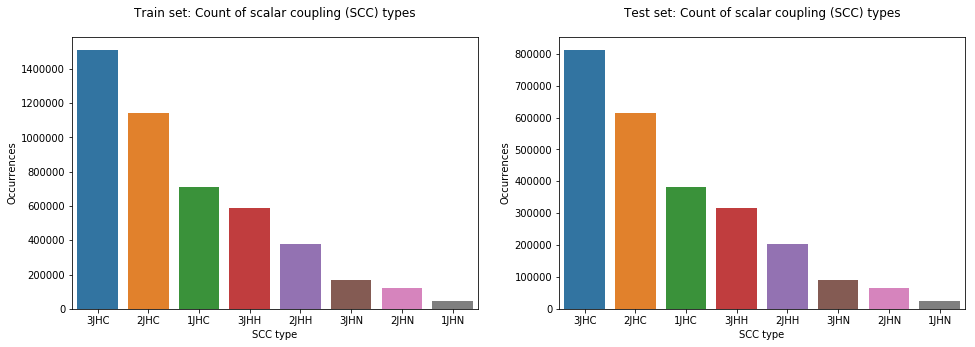

In [0]:
# Count of scalar coupling (SCC) types in training and test sets and compare

type_counts_train = train["type"].value_counts()
type_counts_test = test["type"].value_counts()

fig, ax = plt.subplots(figsize=(16,5), sharey=True)
types = ['3JHC', '2JHC', '1JHC', '3JHH', '2JHH', '3JHN', '2JHN', '1JHN']

plt.subplot(1,2,1)
ax = sns.barplot(types, type_counts_train)
ax.set_ylabel("Occurrences")
ax.set_xlabel("SCC type")
ax.set_title("Train set: Count of scalar coupling (SCC) types", pad="20")

plt.subplot(1,2,2)
ax = sns.barplot(types, type_counts_test)
ax.set_ylabel("Occurrences")
ax.set_xlabel("SCC type")
ax.set_title("Test set: Count of scalar coupling (SCC) types", pad="20")

plt.show()

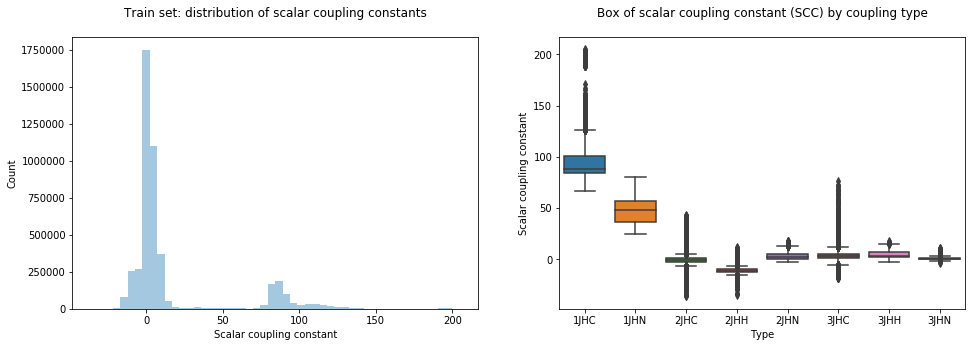

In [0]:
# Examine the coupling contasnts: distribution and relation to coupling type
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(1,2,1)
ax = sns.distplot(train['scalar_coupling_constant'], bins=50, kde=False)
ax.set_xlabel("Scalar coupling constant")
ax.set_ylabel("Count")
ax.set_title("Train set: distribution of scalar coupling constants", pad="20")

plt.subplot(1,2,2)
ax = sns.boxplot(x='type', y='scalar_coupling_constant', data=train)
ax.set_xlabel("Type")
ax.set_ylabel("Scalar coupling constant")
plt.title('Box of scalar coupling constant (SCC) by coupling type', pad='20')

plt.show()

In [0]:
# Read structures.csv and load into dataframe
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures = pd.read_csv(path+'/structures.csv', dtype=structures_dtypes)

print('Structures dataset:')
display(structures.head(5))

Structures dataset:


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [0]:
# examine the structures dataset
structures_data_rows = structures.shape[0]
structures_unique_mols = structures["molecule_name"].nunique()
atom_types = structures["atom"].unique()
print(f'STRUCTURES')
print(f'==========')
print(f'Number rows in structures set: {structures_data_rows}')
print(f'Unique molecules: {structures_unique_mols}')
print(f'Unique atoms: {len(atom_types)} {atom_types}\n')
print(f'Check \'structures\' contains same number of molecules as \'train\' and \'test\'  combined: {"True" if structures_unique_mols == train_unique_mols+test_unique_mols else "False"}')
print(f'Check for missing values: {"None" if structures.isnull().sum().sum() == 0 else structures.isnull().sum()}')


# any molecules/rows not in test and train set
# any missing data in rows

STRUCTURES
Number rows in structures set: 2358657
Unique molecules: 130775
Unique atoms: 5 [C, H, N, O, F]
Categories (5, object): [C, H, N, O, F]

Check 'structures' contains same number of molecules as 'train' and 'test'  combined: True
Check for missing values: None


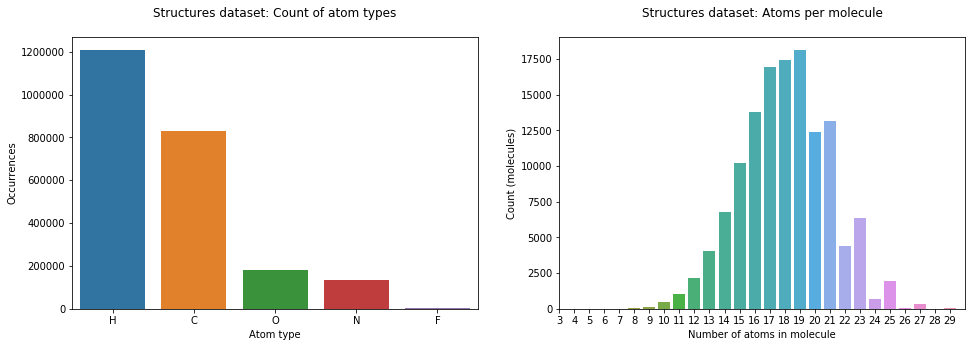

In [0]:
# Distribution of atom types in structures df

atom_counts = structures["atom"].value_counts()
counts_raw  = structures["atom_index"].value_counts()
cum_c = 0
atoms_per_mol = []
for c in reversed(counts_raw):
    atoms_per_mol.append(c-cum_c)
    cum_c += c-cum_c
atoms_per_mol.reverse()

fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(1,2,1)
ax = sns.barplot(['H', 'C', 'O', 'N', 'F'], atom_counts)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Atom type")
ax.set_title("Structures dataset: Count of atom types", pad="20")
plt.subplot(1,2,2)

ax = sns.barplot(list(range(1,30)), atoms_per_mol)
ax.set_ylabel("Count (molecules)")
ax.set_xlabel("Number of atoms in molecule")
ax.set_title("Structures dataset: Atoms per molecule", pad="20")
ax.set(xlim=(2,29))

plt.show()

## Feature Engineering I: Chemical bond numbers and lengths

In [0]:
# Calculate chemical bonding of each atom (number bonds, index atom(s) bonded to and bond length(s))
# Code adapted from Aaron Koch, 'Recovering bonds from structure' public kernal
# Returns datafarme of bonding data

def add_bonds(structures):
    
    atom_rad= {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71}          
    structures['rad'] = [atom_rad[x] for x in structures['atom'].values]
    
    bonding_margin= 0.05
    index_atom = structures['atom_index'].values
    p_comp = p = structures[['x','y','z']].values
    m_comp = m = structures['molecule_name'].values
    r_comp = r = structures['rad'].values + bonding_margin

    src_row = np.arange(len(structures))
    max_atoms = 29
    bonds = np.zeros((len(structures)+1, max_atoms), dtype=np.int8)
    bond_dists = np.zeros((len(structures)+1, max_atoms), dtype=np.float32)
    
    for i in tqdm(range(max_atoms-1), desc="Calculating bonds: "):
        p_comp = np.roll(p_comp, -1, axis=0)
        m_comp = np.roll(m_comp, -1, axis=0)
        r_comp = np.roll(r_comp, -1, axis=0)

        mask = np.where(m == m_comp, 1, 0)
        dists = np.linalg.norm(p - p_comp, axis=1) * mask
    
        r_bond = r + r_comp
        bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)

        targ_row = src_row + i +1
        targ_row = np.where(np.logical_or(targ_row > len(structures), mask==0), len(structures), targ_row)

        src_atom = index_atom
        targ_atom = index_atom + i + 1
        targ_atom = np.where(np.logical_or(targ_atom > max_atoms-1, mask==0), max_atoms-1, targ_atom)

        bonds[(src_row, targ_atom)] = bond
        bonds[(targ_row, src_atom)] = bond
        bond_dists[(src_row, targ_atom)] = dists
        bond_dists[(targ_row, src_atom)] = dists

    bonds = np.delete(bonds, axis=0, obj=-1)
    bonds = np.delete(bonds, axis=1, obj=-1)
    bond_dists = np.delete(bond_dists, axis=0, obj=-1)
    bond_dists = np.delete(bond_dists, axis=1, obj=-1)
    
    print('Processing bond calculations...')
    bonds_to = [[i for i, x in enumerate(row) if x] for row in bonds]
    bond_lengths = [[dist for i, dist in enumerate(row) if i in bonds_to[j]] for j,row in enumerate(bond_dists)]
    n_bonds = [len(x) for x in bonds_to]
   
    print('Creating bonds dataframe...')
    bonds_df = pd.DataFrame({'num_bonds':n_bonds, 'bond_lengths':bond_lengths})
    bonds_df[['bond_len1', 'bond_len2', 'bond_len3', 'bond_len4']] = pd.DataFrame(bonds_df.bond_lengths.values.tolist())
    bonds_df.fillna({'bond_len1':0, 'bond_len2':0, 'bond_len3':0, 'bond_len4':0}, inplace=True) # replace NaN's with 0's
    bonds_df.drop('bond_lengths', axis=1, inplace=True)
    
    structures.drop('rad', axis=1, inplace=True) #needed only for bonding calculations
    
    print(f'Check \'bonds dataframe\' contains same number of rows as \'structures\': {"True" if structures_data_rows == bonds_df.shape[0] else "False"}')
    return bonds_df

In [0]:
# Add bonding lengths to structures dataset 

print('Adding bonding features \'num_bonds\' & \'bond_len(1-4)\' to \'structures\' ')
bonds_df = add_bonds(structures)
structures = structures.join(bonds_df)
structures.head()

Adding bonding features 'num_bonds' & 'bond_len(1-4)' to 'structures' 



Processing bond calculations...
Creating bonds dataframe...
Check 'bonds dataframe' contains same number of rows as 'structures': True


,molecule_name,atom_index,atom,x,y,z,num_bonds,bond_len1,bond_len2,bond_len3,bond_len4
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1,1.091953,0.000000,0.000000,0.000000
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1,1.091952,0.000000,0.000000,0.000000
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1,1.091946,0.000000,0.000000,0.000000
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1,1.091948,0.000000,0.000000,0.000000


In [0]:
# Map atom structures data into train and test sets

def map_structure_data(df, atom_idx):
    df = pd.merge(df, structures, how='left',
                 left_on = ['molecule_name', f'atom_index_{atom_idx}'],
                 right_on = ['molecule_name', 'atom_index'])
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x':f'x_{atom_idx}',
                            'y':f'y_{atom_idx}',
                            'z':f'z_{atom_idx}',
                           })
    return df

In [0]:
# Add structure data to train and test sets
# Drop redundant bond features and rename some others for clarity

def add_structures(df):
    df = map_structure_data(df, 0)
    df = map_structure_data(df, 1)
    df = df.drop(['num_bonds_x', 'bond_len1_x', 'bond_len2_x', 'bond_len3_x', 'bond_len4_x'], axis=1)
    df = df.rename(columns={'num_bonds_y':'num_bonds_atom_1',
                            'bond_len1_y':'bond_len1',
                            'bond_len2_y':'bond_len2',
                            'bond_len3_y':'bond_len3',
                            'bond_len4_y':'bond_len4'
                           })
    return df

print('Merging \'structures\' with \'train\' and \'test\'')
train = add_structures(train)
test = add_structures(test)

train.head()

Merging 'structures' with 'train' and 'test'


,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4
0,dsgdb9nsd_000001,1,0,1JHC,84.807602,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948
1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1,1.091952,0.000000,0.000000,0.000000
2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1,1.091946,0.000000,0.000000,0.000000
3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1,1.091948,0.000000,0.000000,0.000000
4,dsgdb9nsd_000001,2,0,1JHC,84.807404,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948


## Feature Engineering II: Distances features

In [0]:
# Calculate distance between coupled atoms and distance to center atom 
# Remember the positions x_0, x_1, y_0 etc are cartesian co-ordinates
def calc_distances(df):
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    p_0 = df[['x_0', 'y_0', 'z_0']].values
    p_1 = df[['x_1', 'y_1', 'z_1']].values
    df['distance_vector'] = np.linalg.norm(p_0 - p_1, axis=1)
    
    df['cent_x'] = ((df['x_0'] - df['x_1'])) * np.float32(0.5)
    df['cent_y'] = ((df['y_0'] - df['y_1'])) * np.float32(0.5)
    df['cent_z'] = ((df['z_0'] - df['z_1'])) * np.float32(0.5)
    df['distance_center'] = ((
        (df['cent_x'] - df['x_1']) ** np.float32(2) + 
        (df['cent_y'] - df['y_1']) ** np.float32(2) +
        (df['cent_z'] - df['z_1']) ** np.float32(2)
    ) ** np.float32(0.5))

calc_distances(train)
calc_distances(test)

train.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center
0,dsgdb9nsd_000001,1,0,1JHC,84.807602,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948,0.000220,1.192104,0.000036,1.091953,0.007424,-0.545918,-0.003012,1.631883
1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1,1.091952,0.000000,0.000000,0.000000,1.019253,2.160260,0.000003,1.783120,-0.504790,-0.734891,0.000850,2.670930
2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1,1.091946,0.000000,0.000000,0.000000,0.294812,2.112830,0.771973,1.783147,0.271483,-0.726779,0.439310,2.668176
3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1,1.091948,0.000000,0.000000,0.000000,0.276638,2.085032,0.817978,1.783157,0.262982,-0.721982,-0.452211,2.670223
4,dsgdb9nsd_000001,2,0,1JHC,84.807404,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948,1.049455,0.142844,0.000060,1.091952,0.512214,0.188974,-0.003862,1.039220


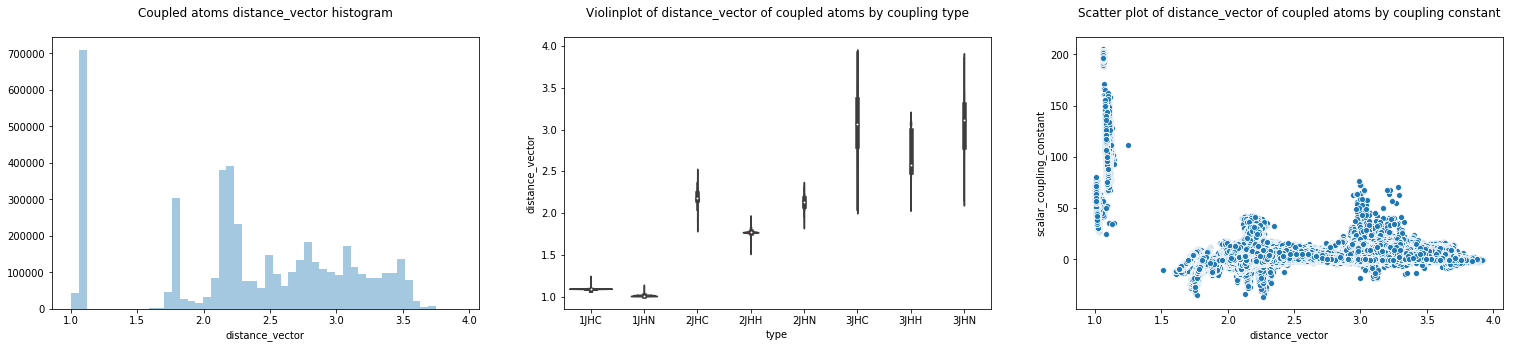

In [0]:
# Lets take a look at the distance_vector feature
def plot_angles_data(data_col):
    fig, ax = plt.subplots(figsize=(26,5))

    plt.subplot(1,3,1)
    sns.distplot(train[data_col], bins=50, kde=False)
    plt.title(f'Coupled atoms {data_col} histogram', pad='20')
    
    plt.subplot(1,3,2)
    sns.violinplot(x='type', y=data_col, data=train)
    plt.title(f'Violinplot of {data_col} of coupled atoms by coupling type', pad='20')
    plt.subplot(1,3,3)
    
    sns.scatterplot(x=data_col, y='scalar_coupling_constant', data=train)
    plt.title(f'Scatter plot of {data_col} of coupled atoms by coupling constant', pad='20')

    fig.show()

plot_angles_data('distance_vector')

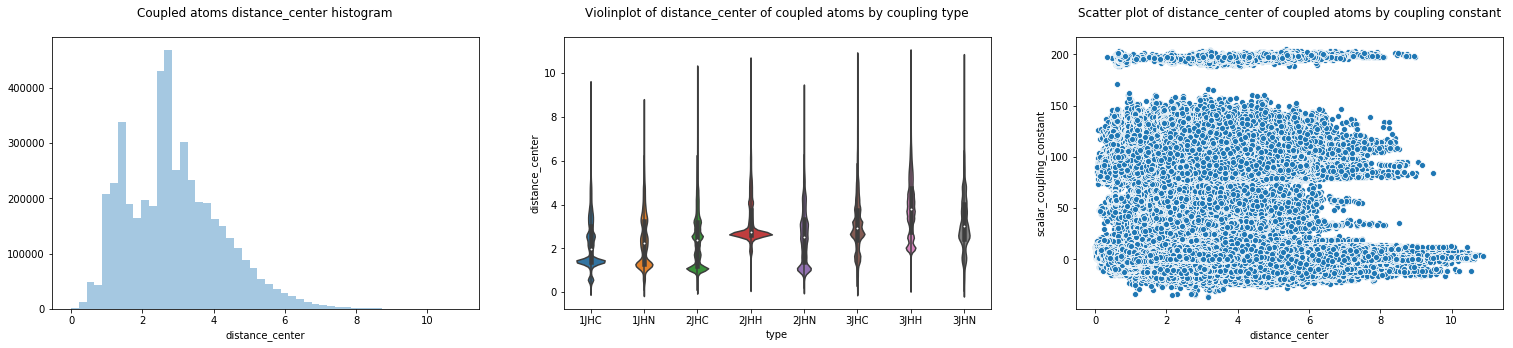

In [0]:
# And the distance_center feature
plot_angles_data('distance_center')

## Feature Engineering II: Cosine and dihedral angles for 2j and 3j couplings

In [0]:
# Load additional file with 2j cosine and 3j dihedral angles already computed for each coupling
# Data file downloaded from https://www.kaggle.com/soerendip/angle-and-dihedral-for-the-champs-structures

angles = pd.read_csv("../input/angle-and-dihedral-for-the-champs-structures/angles.csv")
angles.head()

,molecule_name,atom_index_0,atom_index_1,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,NaN,1,NaN,NaN
1,dsgdb9nsd_000001,1,2,C,2,-0.33329,NaN
2,dsgdb9nsd_000001,1,3,C,2,-0.33333,NaN
3,dsgdb9nsd_000001,1,4,C,2,-0.33335,NaN
4,dsgdb9nsd_000001,2,0,NaN,1,NaN,NaN


In [0]:
# Check 'angles' has same number rows as 'train' and 'test' dfs

angles_unique_mols = angles['molecule_name'].nunique()
print(f'Check \'angles\' contains same number of molecules as \'train\' and \'test\'  combined: {"True" if angles_unique_mols == train_unique_mols+test_unique_mols else "False"}')
print(f'Check for missing values: {"None" if angles.isnull().sum().sum() == 0 else angles.isnull().sum()}')

# Merge angles df with train and test dfs

def map_angle_info(df):
    df = pd.merge(df, angles, how='left',
                 left_on = ['molecule_name', 'atom_index_0', 'atom_index_1'],
                 right_on = ['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df
                            
if angles_unique_mols == train_unique_mols+test_unique_mols:
    train = map_angle_info(train)                         
    test = map_angle_info(test)
else: print('Unable to merge dataframes')

train.head(5)

Check 'angles' contains same number of molecules as 'train' and 'test'  combined: True
Check for missing values: molecule_name                  0
atom_index_0                   0
atom_index_1                   0
shortest_path_atoms      1157583
shortest_path_n_bonds          0
cosinus                  4645080
dihedral                 3676340
dtype: int64


,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,1JHC,84.807602,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948,0.000220,1.192104,0.000036,1.091953,0.007424,-0.545918,-0.003012,1.631883,NaN,1,NaN,NaN
1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1,1.091952,0.000000,0.000000,0.000000,1.019253,2.160260,0.000003,1.783120,-0.504790,-0.734891,0.000850,2.670930,C,2,-0.33329,NaN
2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1,1.091946,0.000000,0.000000,0.000000,0.294812,2.112830,0.771973,1.783147,0.271483,-0.726779,0.439310,2.668176,C,2,-0.33333,NaN
3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1,1.091948,0.000000,0.000000,0.000000,0.276638,2.085032,0.817978,1.783157,0.262982,-0.721982,-0.452211,2.670223,C,2,-0.33335,NaN
4,dsgdb9nsd_000001,2,0,1JHC,84.807404,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948,1.049455,0.142844,0.000060,1.091952,0.512214,0.188974,-0.003862,1.039220,NaN,1,NaN,NaN


In [0]:
# # Remove NaNs from angles if required
# if angles.isnull().sum().sum() != 0: 
#     angles.fillna({'cosinus':0, 'dihedral':0, 'shortest_path_atoms':'H'}, inplace=True)

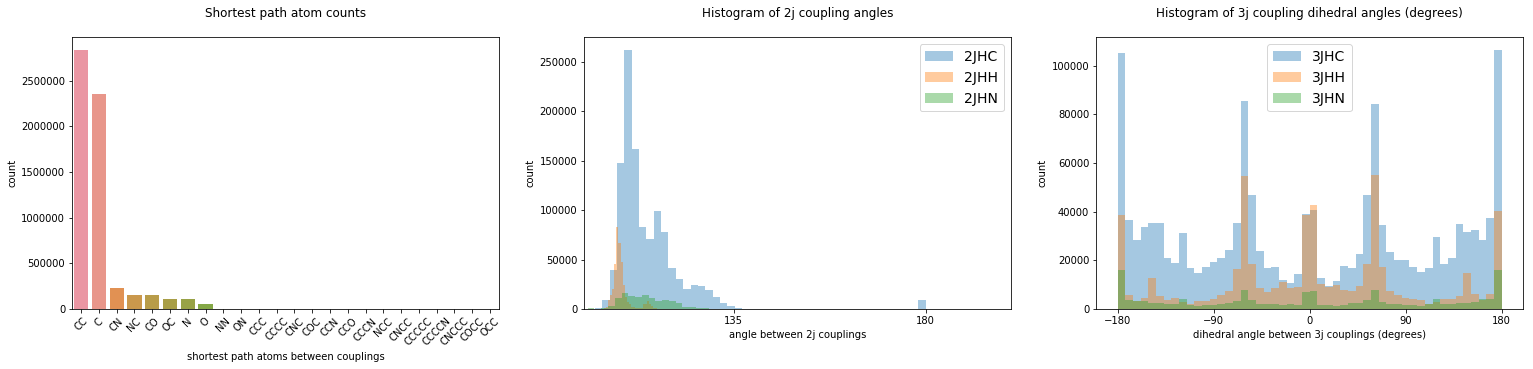

In [0]:
# Let's take a look at coupling angles 

import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(26,5))

plt.subplot(1,3,1)
couple_paths = angles['shortest_path_atoms'].value_counts()
barplt = sns.barplot(couple_paths.keys(), couple_paths.values)
barplt.set_xticklabels(couple_paths.keys(), rotation=45)
barplt.set(xlabel='shortest path atoms between couplings', ylabel='count')
plt.title('Shortest path atom counts', pad='20')

plt.subplot(1,3,2)
cosine_ang_2JHC = np.degrees(np.arccos(train[train.type=='2JHC']['cosinus']))
cosine_ang_2JHH = np.degrees(np.arccos(train[train.type=='2JHH']['cosinus']))
cosine_ang_2JHN = np.degrees(np.arccos(train[train.type=='2JHN']['cosinus']))
cosplt = sns.distplot(cosine_ang_2JHC, bins=50, label='2JHC', kde=False, )
cosplt = sns.distplot(cosine_ang_2JHH, bins=50, label='2JHH', kde=False, )
cosplt = sns.distplot(cosine_ang_2JHN, bins=50, label='2JHN', kde=False, )
cosplt.set(xlabel='angle between 2j couplings', ylabel='count')
axes = cosplt.axes
axes.set_xlim(100, 200,)
axes.xaxis.set_major_locator(ticker.MultipleLocator(45))
plt.legend(fontsize=14)
plt.title('Histogram of 2j coupling angles', pad='20')

plt.subplot(1,3,3)
dihedral_ang_3JHC = np.degrees(train[train.type=='3JHC']['dihedral'])
dihedral_ang_3JHH = np.degrees(train[train.type=='3JHH']['dihedral'])
dihedral_ang_3JHN = np.degrees(train[train.type=='3JHN']['dihedral'])
dihplt = sns.distplot(dihedral_ang_3JHC, bins=50, label='3JHC', kde=False)
dihplt = sns.distplot(dihedral_ang_3JHH, bins=50, label='3JHH', kde=False)
dihplt = sns.distplot(dihedral_ang_3JHN, bins=50, label='3JHN', kde=False)
dihplt.set(xlabel='dihedral angle between 3j couplings (degrees)', ylabel='count')
axes = dihplt.axes
axes.set_xlim(-200, 200,)
axes.xaxis.set_major_locator(ticker.MultipleLocator(90))
plt.legend(fontsize=14)
plt.title('Histogram of 3j coupling dihedral angles (degrees)', pad='20')

fig.show()

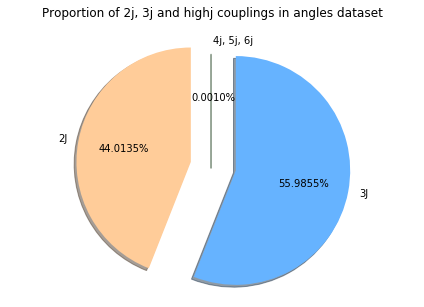

Number of higher order (>3j) couplings: 148

What are the coupling constants for higher order (>3j) couplings?
Higher order coupling cosine angle value counts: {148: 0.0}
Higher order coupling dihedral angle value counts: {148: 0.0}


In [0]:
# Proportion of long range (4j, 5j & 6J) couplings

couple_paths = angles['shortest_path_atoms'].value_counts()
couple_paths_2j = sum(couple_paths[np.array([1,2,7,8])])
couple_paths_3j = sum(couple_paths[np.array([0,3,4,5,6,9,10])])
couple_paths_highj = sum(couple_paths.values[11:])

labels = ['2J', '3J', '4j, 5j, 6j']
sizes = [couple_paths_2j, couple_paths_3j, couple_paths_highj]
explode = (0.2, 0.2, 0)  
fig1, ax1 = plt.subplots()
colors = ['#ffcc99','#66b3ff','#99ff99']
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.4f%%', shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Proportion of 2j, 3j and highj couplings in angles dataset", pad=20)
plt.show()

angles_highj = angles[angles['shortest_path_n_bonds'] > 3]
angles_highj['cosinus'].values
print(f'Number of higher order (>3j) couplings: {len(angles_highj)}')


print('\nWhat are the coupling constants for higher order (>3j) couplings?')
angles_highj.fillna({'cosinus':0, 'dihedral':0}, inplace=True)
unique, counts = np.unique(angles_highj['cosinus'].values, return_counts=True)
print(f'Higher order coupling cosine angle value counts: {dict(zip(counts, unique))}')
unique, counts = np.unique(angles_highj['dihedral'].values, return_counts=True)
print(f'Higher order coupling dihedral angle value counts: {dict(zip(counts, unique))}')

In [0]:
# # Remove the 148 higher order couplings from the train and test sets as invalid data (it should have only 1j, 2j and 3j couplings)
# # Must also be removed from submission.csv if we intend to submit the resuklts to kaggle
# train = train.loc[train.shortest_path_n_bonds<4,:]
# test = test.loc[test.shortest_path_n_bonds<4, :]

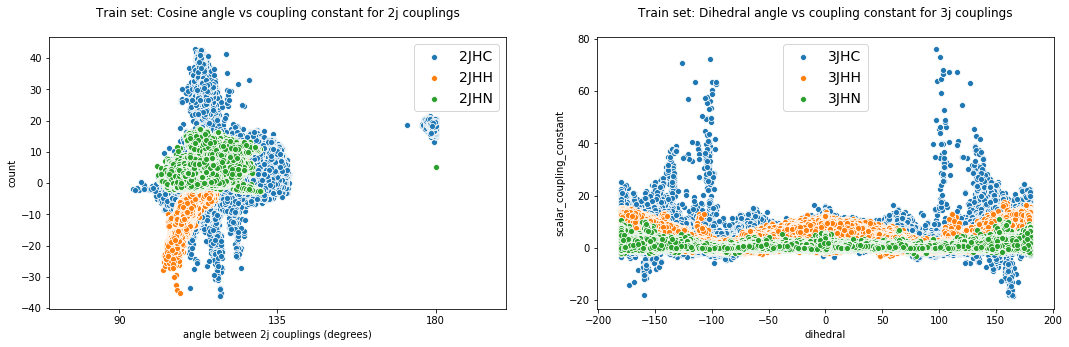

In [0]:
# Examine relationship between angles and coupling constant
SCC_2JHC = train[train.type == '2JHC']['scalar_coupling_constant']
SCC_2JHH = train[train.type == '2JHH']['scalar_coupling_constant']
SCC_2JHN = train[train.type == '2JHN']['scalar_coupling_constant']
SCC_3JHC = train[train.type == '3JHC']['scalar_coupling_constant']
SCC_3JHH = train[train.type == '3JHH']['scalar_coupling_constant']
SCC_3JHN = train[train.type == '3JHN']['scalar_coupling_constant']

fig, ax = plt.subplots(figsize=(18,5))

plt.subplot(1,2,1)
# cosplt = sns.scatterplot(x=np.degrees(np.arccos(data_2j["cosinus"])), y=data_2j['scalar_coupling_constant'])
cosplt = sns.scatterplot(x=cosine_ang_2JHC, y=SCC_2JHC, label='2JHC')
cosplt = sns.scatterplot(x=cosine_ang_2JHH, y=SCC_2JHH, label='2JHH')
cosplt = sns.scatterplot(x=cosine_ang_2JHN, y=SCC_2JHN, label='2JHN')
axes = cosplt.axes
axes.set_xlim(70, 200,)
axes.xaxis.set_major_locator(ticker.MultipleLocator(45))
cosplt.set(xlabel='angle between 2j couplings (degrees)', ylabel='count')
plt.legend(fontsize=14)
plt.title('Train set: Cosine angle vs coupling constant for 2j couplings', pad='20')

plt.subplot(1,2,2)
dihPlt = sns.scatterplot(x=dihedral_ang_3JHC, y=SCC_3JHC, label='3JHC')
dihPlt = sns.scatterplot(x=dihedral_ang_3JHH, y=SCC_3JHH, label='3JHH')
dihPlt = sns.scatterplot(x=dihedral_ang_3JHN, y=SCC_3JHN, label='3JHN')
axes = dihplt.axes
axes.set_xlim(-200, 200,)
axes.xaxis.set_major_locator(ticker.MultipleLocator(90))
dihplt.set(xlabel='dihedral angle between 3j couplings (degrees)', ylabel='count')
plt.legend(fontsize=14)
plt.title('Train set: Dihedral angle vs coupling constant for 3j couplings', pad='20')

fig.show()

## Reduce memory usage

In [0]:
# Check dataframe mem usage
def show_mem_usage(df):
    print('Shape: ', df.shape)
    print('Total Mem usage: ', df.memory_usage().sum())
    df.memory_usage()

In [0]:
# Reduce size of dataframe columns to minimise memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 457.56 Mb (32.7% reduction)
Mem. usage decreased to 236.56 Mb (33.6% reduction)


## What have we learnt?
1. Coupling types are not evenly represented in the dataset. HC couplings are most numerous and HN couplings least represented.
2. Coupling constants vary between -40hz and 220hz in magnitude, though are roughly grouped with 1J coupling in the range 50-100hz and the 2J and 3J couplings typically -20 to +40Hz
3. Number of atoms in molecules varies between 3 and 29 with most molecules in the dataset having between 12 anD 24 atoms
4. Plotting vector distance vs SCC does reveals some rough groupings but the only real corrolation appears to be between the  distance between coupled atoms and increasing Jcouple (1J < 2J < 3J) This is expected as 1J coupled atoms are bonded to each other, while 2J coupled atoms are bonded to a common third atoma and 3J couples have two intervening atoms.
5. There are some distinct patterns and groupings by coupling type when the cosine and dihedral angles of 2j and 3j couples are plotted against SCC. These almost certainly reflect bonding geometries around the inter-couple atoms but do not appear to have any simple corrolations. 
6. There are a  small number 148 (0.0021%) of longer range couplings (4J , 5j and 6J) in the dataset which may be seen as invalid data. We have saved their indexes so we can remove them from the training and test sets if needed

The next step is to use these features for training and prediction. See https://www.kaggle.com/mathewhall/champs-molecular-properties-gb-model and https://www.kaggle.com/mathewhall/champs-molecular-properties-nn-models/



## Save datasets
Saved files are available for download from 'kernal outputs'

In [0]:
# save train and test dataframes
train.to_csv('train_features.csv',index=False)
test.to_csv('test_features.csv',index=False)